# Introduction

Author: David Yin, yinzhen@stanford.edu; Lijing Wang, lijing52@stanford.edu; Jef Caers, jcaers@stanford.edu (2020)

Outliers are of primary interest in geochemical data analysis. For example, in groundwater remediations, outliers are used to identify locations with water contaminations. Detecting the outliers is therefore one main task in the statistical analysis of geochemical data. 


In [ ]:
## load compositional data analysis package
! pip install scikit-bio
from skbio.stats.composition import *

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import MinCovDet

Let's get back to the groundwater geochemistry in California’s central valley. 

Consider yourself as a director that oversees the groundwater quality in this area (e.g. executive director of California Water Board). The groundwater you manage provides drinking water to 7 million residents and irrigation for California's most productive agriculture. As a director, one of your responsibility is to quickly identify contaminations so that remediation can be taken before it's too late.

Some major pollutants that concern you are geogenic contaminants, such as Chromium (Cr) and Arsenic (As). These chemicals are toxic to humans, animals and agriculture.

Your data vendor recently provided the geochemical data at different sites across the central valley. You have explored that geochemitry dataset in the previous chapter using compositional data analsis. Now we are ongoing using these data to detect anomalies (**outliers**) from the contaminated sites. 

![landuse.jpg](https://drive.google.com/uc?export=view&id=1M62JIu9cKtztoxiWIMILUQ3yrkxobtF8)




In [ ]:
## Clone data from our GitHub repository
! git clone https://github.com/lijingwang/GEOLSCI6_EARTHSYS100A.git
# Load geochem dataset, groundwater chemistry in Central Valley
data = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/StatsGeochem/Datapoints-CentralValley-Groundwater-Jan2019.csv')
compositional_data = np.array(data.values[:,6:(6+22)],dtype = 'float64')
columns_name = data.columns[6:(6+22)]

Cloning into 'GEOLSCI6_EARTHSYS100A'...
remote: Enumerating objects: 125, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 125 (delta 52), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (125/125), 163.04 KiB | 4.79 MiB/s, done.
Resolving deltas: 100% (52/52), done.


# Detect Cr contamination


### Univariate outliers

Our first task to detect high Cr concentration anormalies. Below the distribution of Cr concentrations is plotted. 

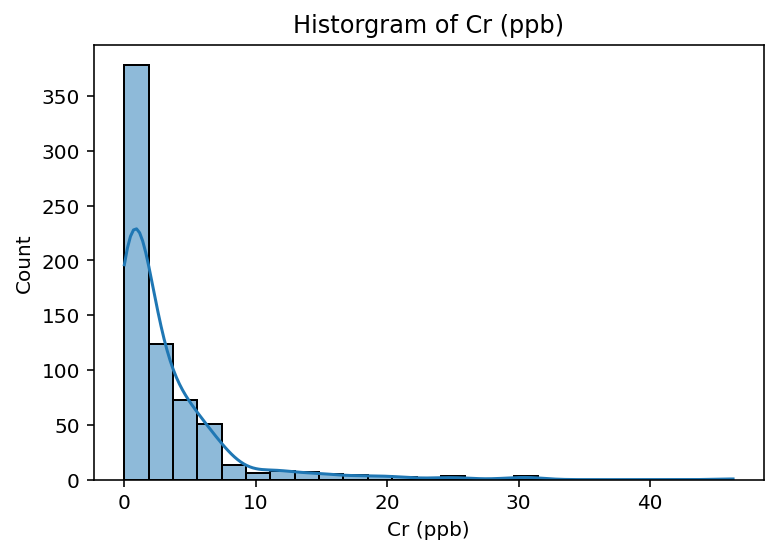

In [ ]:
## Histogram of raw Cr data
sns.histplot(data=data['Cr (ppb)'], bins=25, kde=True)
plt.title('Historgram of Cr (ppb)')
plt.show()

The historgram clearly shows a skewed distribution of Cr. We can see the main data population remains below 10ppb (Safety Level). But there is a long tail, suggesting extreme high Cr concentrations at some spots. These extreme high concentrations should raise alert. 

Can we use extreme value statistics to identify Cr contaminated outliers? We create a exponential quantile plot below. 


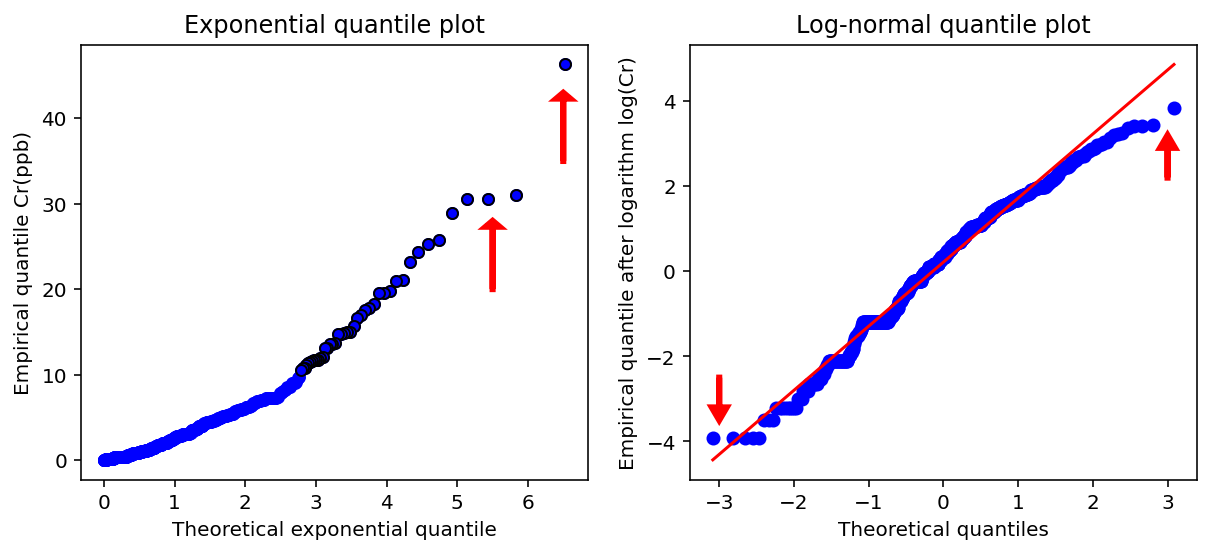

In [ ]:
## Make exponential quantile plot
plt.figure(figsize=(10,4))
plt.subplot(121)
indata = data['Cr (ppb)']
indata = np.sort(indata)[::-1]
n = len(indata)
P_X_larger_x = np.arange(1,n+1)/(n+1)
plt.scatter(-np.log(P_X_larger_x), indata, s=30, c='b')
plt.scatter(-np.log(P_X_larger_x)[indata>10], indata[indata>10], s=30, c='b', edgecolors='k')
plt.arrow(5.5, 20, 0, 8, length_includes_head=True, color='r',
          linewidth=3, head_width=0.2, head_length=0.7)
plt.arrow(6.5, 35, 0, 8, length_includes_head=True, color='r',
          linewidth=3, head_width=0.2, head_length=0.7)
plt.xlabel('Theoretical exponential quantile')
plt.ylabel('Empirical quantile Cr(ppb)')
plt.title('Exponential quantile plot')

## Make exponential quantile plot
plt.subplot(122)
stats.probplot(np.log(data['Cr (ppb)']), plot=plt)
plt.arrow(-3, -2.5, 0, -1, length_includes_head=True, color='r',
          linewidth=3, head_width=0.2, head_length=0.3)
plt.arrow(3, 2.2, 0, 1, length_includes_head=True, color='r',
          linewidth=3, head_width=0.2, head_length=0.3)
plt.ylabel('Empirical quantile after logarithm log(Cr)')
plt.title('Log-normal quantile plot')
plt.show()

The quantile plot show a straightiline between the main data populations (Cr <=10ppb) and theoretical exponential quantiles. The high Cr values clearly stand out as outliers. Those outliers are above the Alert Level (Cr >10ppb). 

In the log-normal quantile plot, we observe the tails of both high and low Cr values as outliers. 

Another way to detect outliers is applying boundary. 

The historgram below for Cr concentrations in logarithm shows a "bell" shape of normal distribution, as suggested from the QQ plot. You can make a boundary using 2.5% and 97.5% quantiles. That gives us 95% confidence intervals to classify the data outside the boundary as outliers 


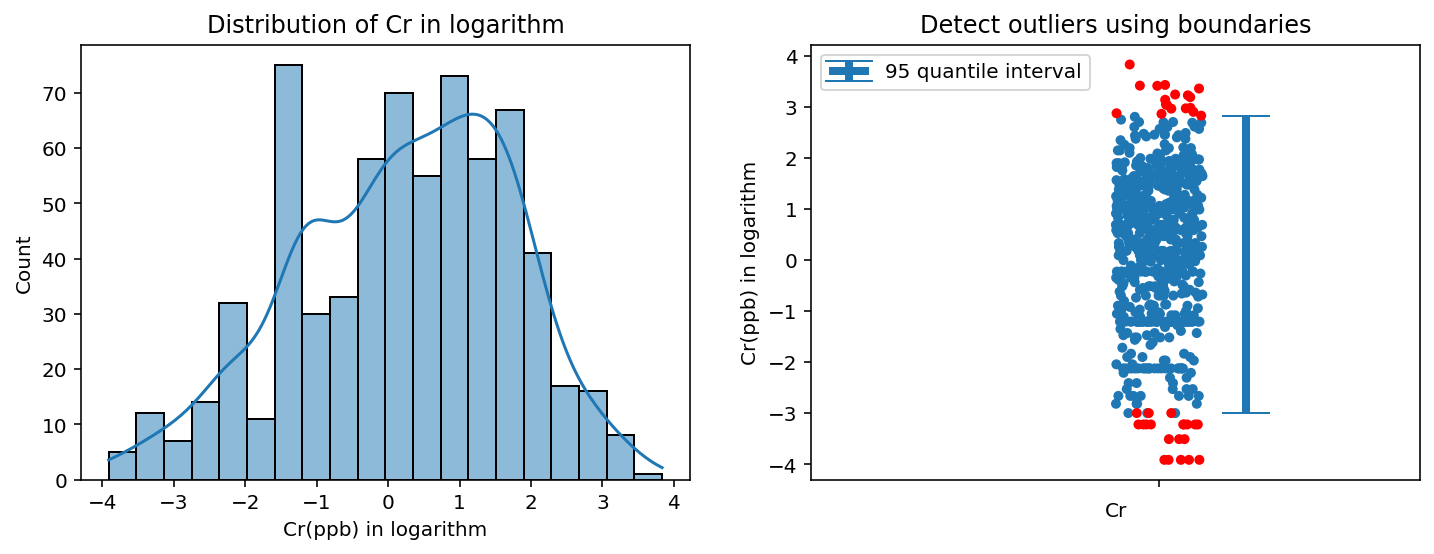

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.histplot(data=np.log(data['Cr (ppb)']), bins=20, kde=True)
plt.xlabel('Cr(ppb) in logarithm')
plt.title('Distribution of Cr in logarithm')

### apply a threshold from 2.5 and 97.5 quantiles
plt.subplot(122)
pltdata = np.log(data['Cr (ppb)'].values)
## determin boundary by quantiles
p_025, p_975 = np.quantile(pltdata, 0.025), np.quantile(pltdata, 0.975)
outlier_index = (pltdata>=p_975)|(pltdata<=p_025)
sns.stripplot(y=pltdata[(pltdata<=p_975) & (pltdata>=p_025)], jitter=0.05)
sns.stripplot(y=pltdata[outlier_index], color = 'r', jitter=0.05)
plt.errorbar(0.1, (p_975+p_025)/2,(p_975-p_025)/2, lw =4, capsize=12, ls='-.', label='95 quantile interval')

# mu, std  = np.mean(np.log(data['Cr (ppb)'])),  np.std(np.log(data['Cr (ppb)']))
# sns.stripplot(y=[abs(np.log(data['Cr (ppb)']))>2*std]), color="r", jitter=0.05)
# plt.errorbar(0.1, mu,std, lw =4, capsize=12, ls='-.', label=r'$\sigma$')
# plt.errorbar(-0.1, mu,2*std, lw=4, capsize=12, label=r'$2\sigma$')
plt.xlim(-0.4, 0.3)
plt.title('Detect outliers using boundaries')
plt.ylabel('Cr(ppb) in logarithm')
plt.xlabel('Cr')
plt.legend()
plt.show()

You can make another plot using 2 standard deviations as boundary. Try to see the differences.

The outliers identified using boundary suggest the cleanest water sites (lowest Cr), and most contaminated site (highest Cr). We can trace back their geographic locations in Central Valley. Compare the outlier locations with the landuse map. Can you observe any correlations?

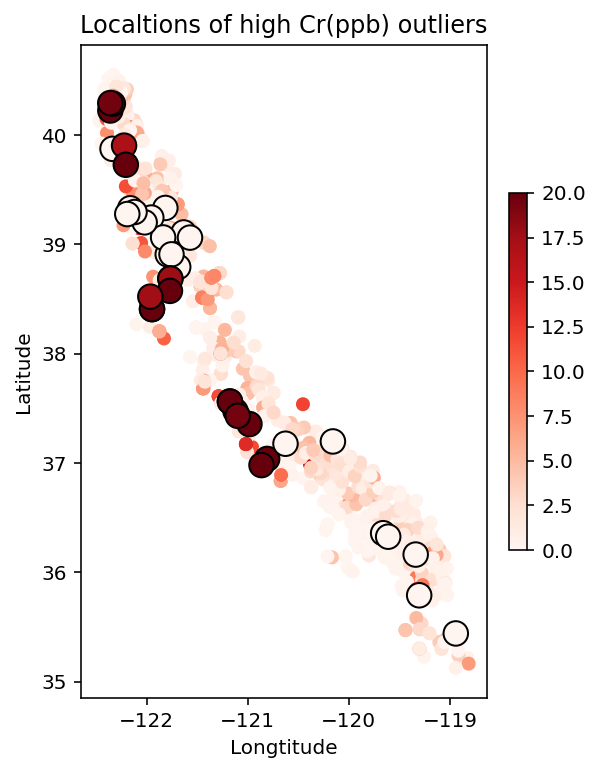

In [ ]:
plt.figure(figsize=(4,6))
plt.scatter(data['Longitude'],data['Latitude'],c = data['Cr (ppb)'],cmap = 'Reds',vmin = 0, vmax = 20)
plt.scatter(data['Longitude'][outlier_index],
            data['Latitude'][outlier_index],
            c = data['Cr (ppb)'][outlier_index], s=150, edgecolor='k',
            cmap = 'Reds',vmin = 0, vmax = 20)
plt.colorbar(fraction=0.04)
plt.title('Localtions of high Cr(ppb) outliers')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.show()

**Question**: 
Try to use the above method to detect outliers in Arsenic. Do you observe any difference from Chromium?

### Outliers or extreme?

In this univariate Cr case, outliers are extreme values. But what are the differences between **outliers** and **extremes**? 

The plot below shows a bivariate distibution of X, Y. The red data point stands out as an outlier from the main population. Clearly the outlier is not an extreme value. It's labelled as outlier because it is not within the main data distribution pattern. "Extreme" mostly relates to the maximum and minimum values of data. Outlier is not only that.

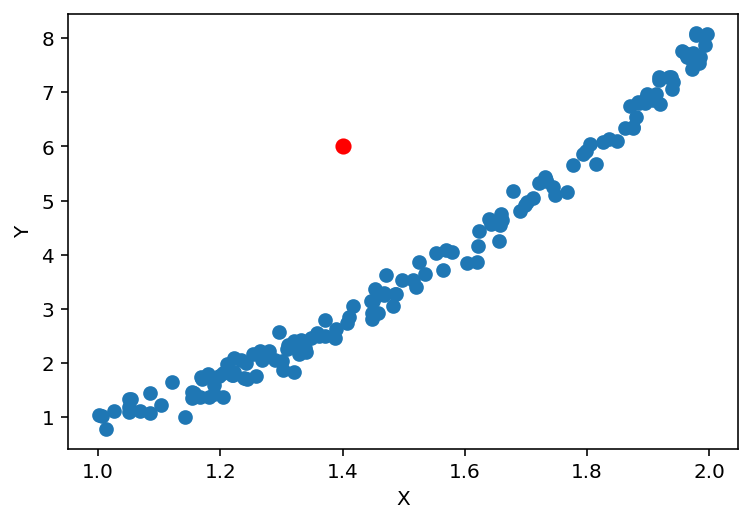

In [ ]:
a = np.random.uniform(1, 2,150)
b = a**3 + np.random.normal(0, 0.2,150)
plt.scatter(a, b, s=40)
plt.scatter(1.4, 6, c='r', s=50)
plt.ylabel('Y')
plt.xlabel('X')
plt.show()

# Contaminations in Cr and As - bivariate outliers

Now you are given two contaminants, Cr and As, how will you detect the outliers for both?  Where will you draw a boundary that separates the outliers?


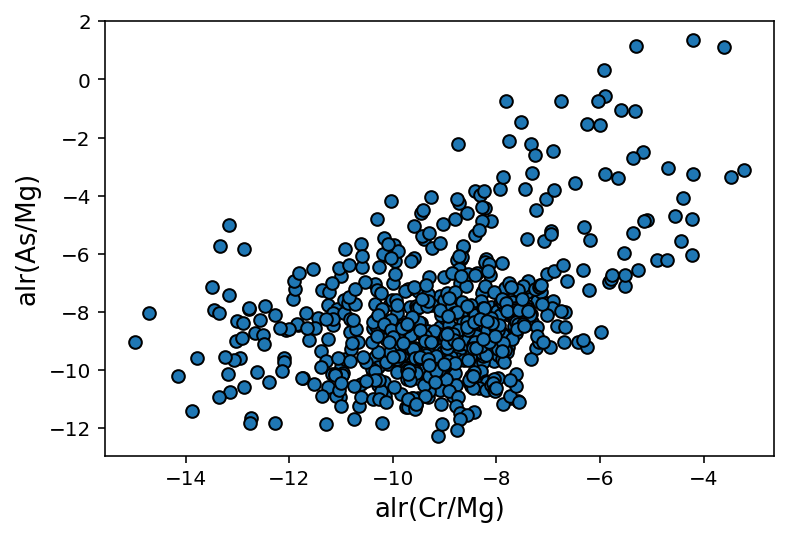

In [ ]:
X = np.c_[np.log(data['Cr (ppb)']/data['Mg (ppb)']), 
          np.log(data['As (ppb)']/data['Mg (ppb)'])]
plt.scatter(X[:, 0], X[:, 1], s=40, edgecolors='k')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.show()

The plot shows the distribution between alr(Cr/Mg) and alr(As/Mg). Apparently, it difficult to simply use quantile plot or draw a straightline with standard deviation. Besides, the two variates might also have correlations that need to be addressed.  

Here, we introduce advanced methods that can quantitatively classify outlier for bivariate or multivariate distributions. 







### Fiting data to elliptical shape - Mahalanobis distance

We want to find out a boundary that separates outliers from the main data. One way is to draw the boundary by following the data shape. 

To determine the data shape, we first calculate the distance from each data sample to the data center. Similar to the univariate case, we also use standard deviation to quantify the distance. For each sample $X_i$ , we calculate how many standard deviations it is away from dataset center:

$$MD(X_i) = \sqrt{(X_i-\mu)^TS^{-1}(X_i-\mu)}, \forall i \in 1, 2, ..., L$$

where $\mu$ is the center (mean) of the data populations. $S$ is the covariance between Cr and As that measures their joint variability. $L$ is the number of data samples. The calculated distance is named as **Mahalanobis distance** (MD). 


The figure below plots the calculated Mahalanobis distance for the As and Cr dataset. 

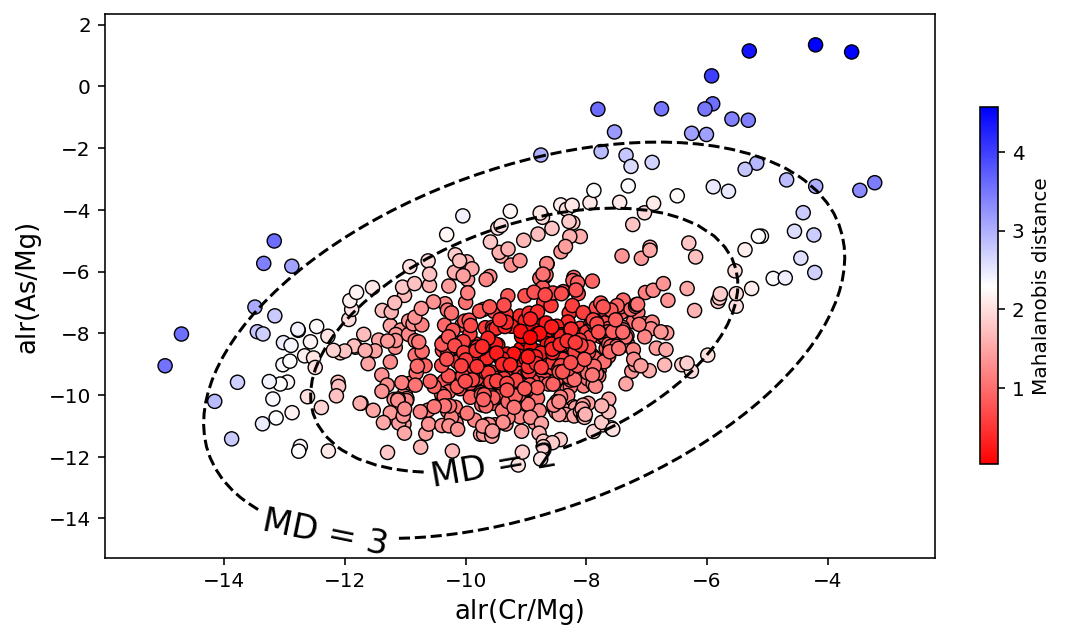

In [ ]:
emp_cov = EmpiricalCovariance().fit(X)
X_maha = np.sqrt(emp_cov.mahalanobis(X))

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1,X[:,0].max()+1),
                     np.linspace(X[:,1].min()-3,X[:,1].max()+1))


emp_cov = EmpiricalCovariance().fit(X)

X_maha = np.sqrt(emp_cov.mahalanobis(X))
mahal_emp_cov = emp_cov.mahalanobis(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plot results
plt.figure(figsize=(8,5))
plt.scatter(X[:, 0], X[:, 1], s=50, c=X_maha, cmap = 'bwr_r',edgecolor='k', linewidths=0.7)
cbar = plt.colorbar(fraction=0.02)
cbar.set_label('Mahalanobis distance')
a = plt.contour(xx, yy, np.sqrt(mahal_emp_cov), levels=[2,3], colors='k', linestyles='--')
plt.clabel(a, fontsize=17, fmt = 'MD = %1.f')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.show()

The plot clearly reveals the elliptical nature of data samples. We can see the majority data populations fall within ellipse MD=2. Data points outside the ellipse are deviated from the main population. As we increase the level of MD, we have outliers that are more deviated. 

### Robust Mahalanobis distance

The problem with Mahalanobis distance is that it highly affected by large values (outliers). 

In the figure below, we compare the MDs calcuated with including and excluding the outliers

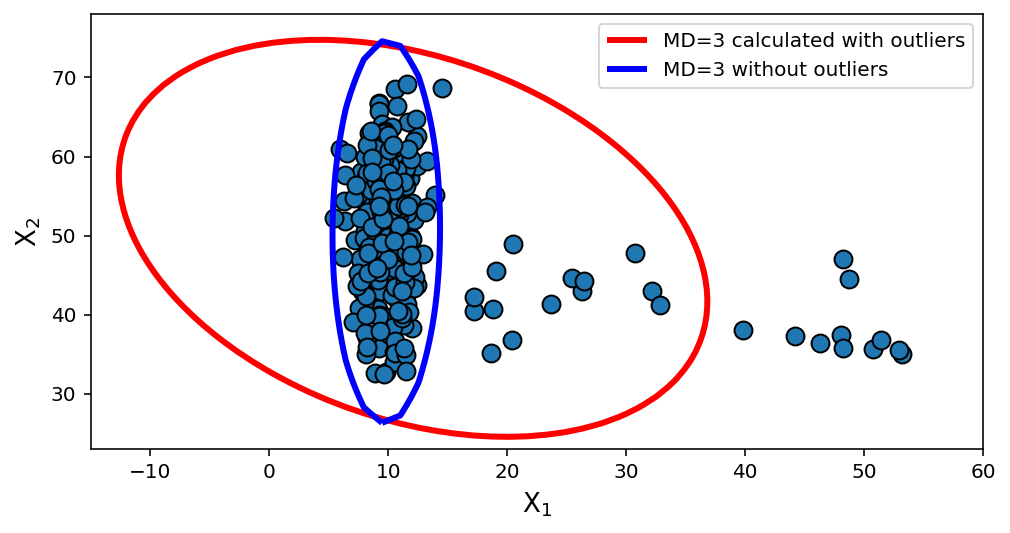

In [ ]:
## create synthetic data
np.random.seed(250)
a = np.r_[np.random.normal(10, 1.5, 250), np.random.uniform(15, 55,25)]
b = np.r_[np.random.normal(50, 8, 250), np.random.uniform(35, 50,25)]

X_t = np.c_[a, b]
np.random.shuffle(X_t)
xx, yy = np.meshgrid(np.linspace(-15,60),
                     np.linspace(23,78))

## empirical MD
new_emp_cov = EmpiricalCovariance().fit(X_t)
X_tmaha = np.sqrt(new_emp_cov.mahalanobis(X_t))
mahal_contour = new_emp_cov.mahalanobis(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

## robust MD
rob_cov = MinCovDet().fit(X_t)
X_tmaha_rob = np.sqrt(rob_cov.mahalanobis(X_t))
mahal_contour_rob = rob_cov.mahalanobis(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8,4))
plt.scatter(X_t[:,0], X_t[:,1], s=80, edgecolors='k')
a = plt.contour(xx, yy, np.sqrt(mahal_contour), levels=[3], colors='r', linewidths=3)
a.collections[0].set_label('MD=3 calculated with outliers')
b = plt.contour(xx, yy, np.sqrt(mahal_contour_rob), levels=[3], colors='b', linewidths=3)
b.collections[0].set_label('MD=3 without outliers')
plt.legend(loc='upper right')

plt.xlabel('X$_1$', fontsize = 13)
plt.ylabel('X$_2$', fontsize = 13)
plt.show()

We need a measure of correlation that is much less affected by outliers.
Below we plot how the convariance determinant of (X$_1$ and X$_2$) changes when dropping out the farthest outliers. 

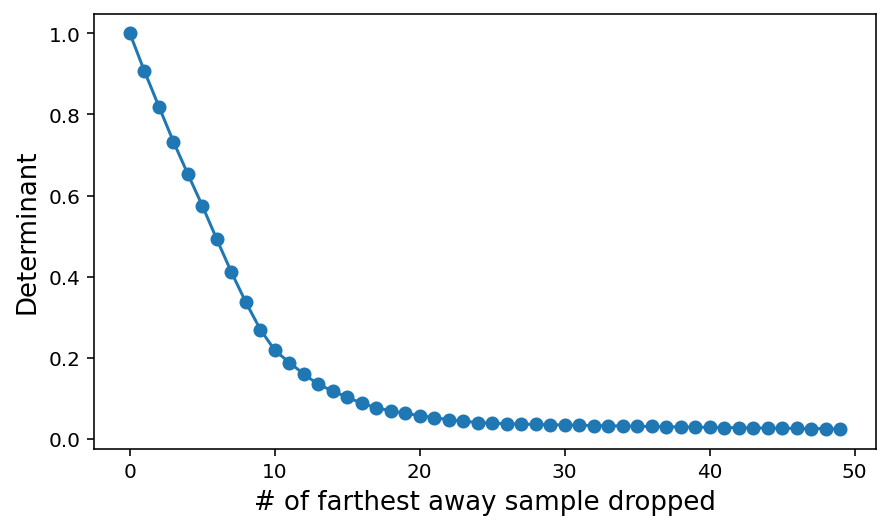

In [ ]:
cov_dets = []
sort_xmaha = np.sort(X_tmaha_rob)[::-1]

for outlier_id in range(50):
  new_X = X_t[X_tmaha_rob<sort_xmaha[outlier_id]]

  newX_cov = EmpiricalCovariance().fit(new_X).covariance_
  cov_dets.append(np.linalg.det(newX_cov))
plt.figure(figsize=(7,4))
plt.plot(cov_dets/np.max(cov_dets), 'C0o-')
np.linalg.det(newX_cov)
plt.xlabel('# of farthest away sample dropped', fontsize = 13)
plt.ylabel('Determinant', fontsize = 13)
plt.show()

We take the covariance with stabilized minimum covariance determinant (MCD). Then use that covariance to recalculate the Mahalanobis distance. In this way, we obtain the **robust Mahalanobis distance**. 

In the figure below, we plot both robust and non-robust Mahalanobis distances for the X$_1$ and X$_2$ bivariate dataset. You can see how different the outliers are above the threshold (MD=3).

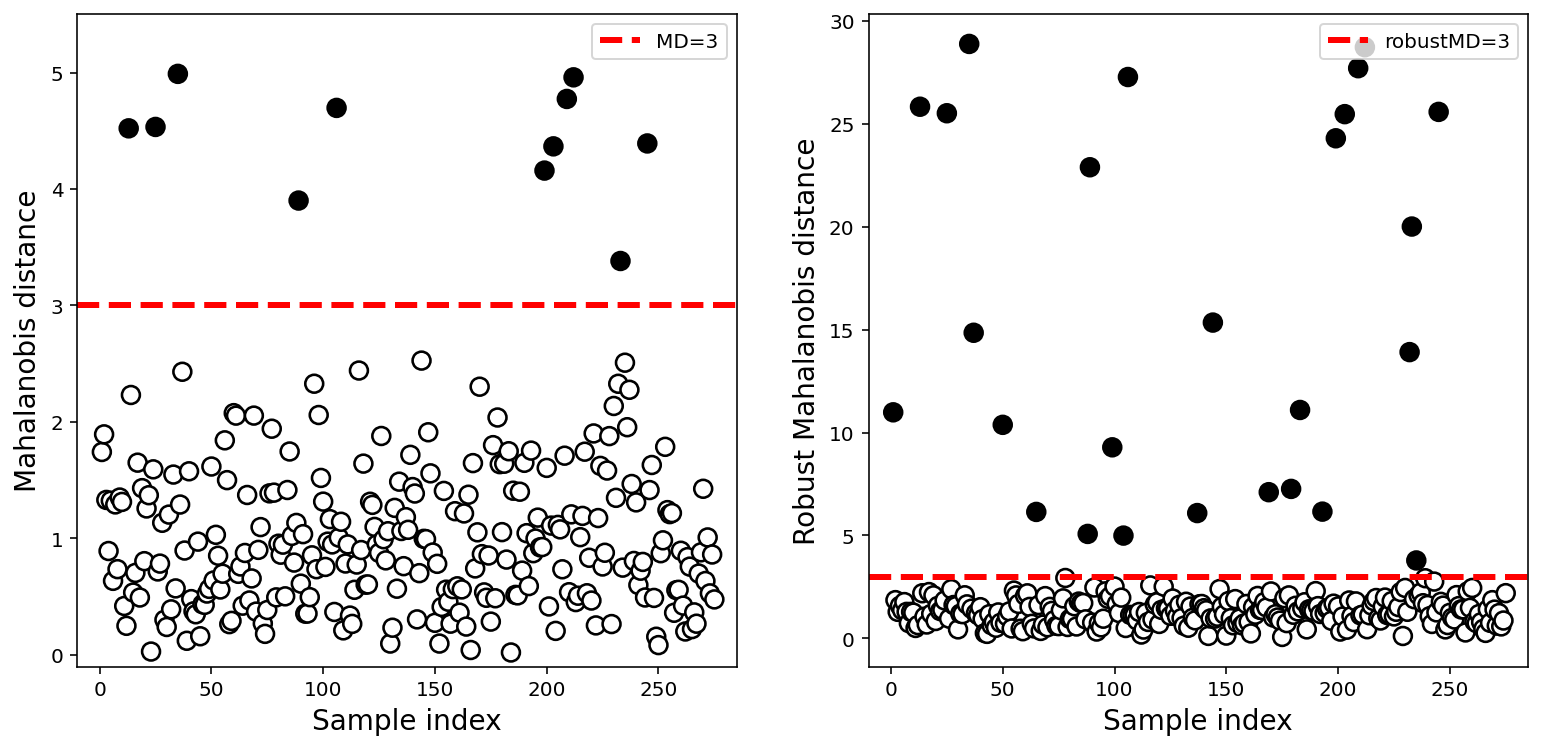

In [ ]:
# plot outliers
plt.figure(figsize=(13, 6))
plt.subplot(121)

outlier_index = (X_tmaha>= 3)
plt.scatter(np.arange(1,(len(X_tmaha)+1)), X_tmaha, c=outlier_index,     \
            cmap ='Greys', s=80, linewidths=1.3, edgecolor='k')

plt.hlines(3, xmin= -10, xmax=(len(X_tmaha)+10), colors='red', linewidths=3, 
           linestyles='--', label='MD=3')
plt.legend(loc="upper right")
plt.ylabel('Mahalanobis distance', fontsize=14)
plt.xlabel('Sample index', fontsize=14)
plt.xlim(-10, (len(X_tmaha_rob)+10))
plt.ylim(-0.1, 5.5)

plt.subplot(122)
outlier_index = (X_tmaha_rob>= 3)
plt.scatter(np.arange(1,(len(X_tmaha_rob)+1)), X_tmaha_rob, c=outlier_index, \
            cmap ='Greys', s=80,  linewidths=1.3, edgecolor='k')

plt.hlines(3, xmin= -10, xmax=(len(X_tmaha_rob)+10), 
           colors='red', linewidths=3, linestyles='--', label='robustMD=3')
plt.legend(loc="upper right")
plt.xlim(-10, (len(X_tmaha_rob)+10))
plt.ylabel('Robust Mahalanobis distance', fontsize=14)
plt.xlabel('Sample index', fontsize=14)
plt.show()

We can also calculate robust Mahalanobis distances for central valley geochemical data alr(As/Mg) and alr(Cr/Mg). See how different they are comparing to the non-robust ones. 

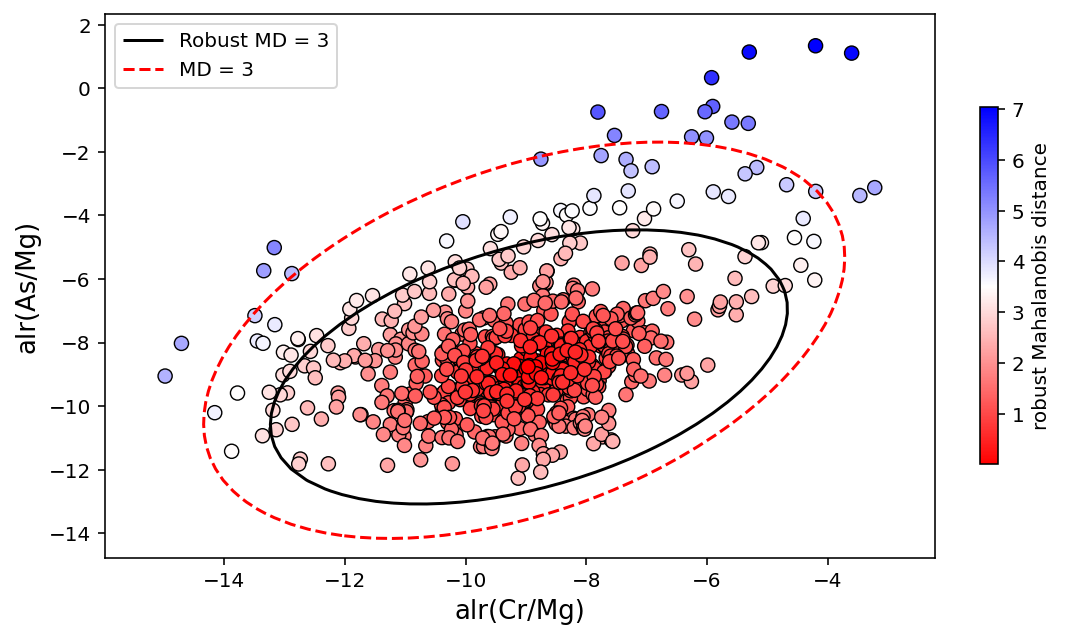

In [ ]:
emp_cov = EmpiricalCovariance().fit(X)
X_maha = np.sqrt(emp_cov.mahalanobis(X))

xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1,X[:,0].max()+1),
                     np.linspace(X[:,1].min()-2.5,X[:,1].max()+1))

rob_cov = MinCovDet().fit(X)

X_maha_rob = np.sqrt(rob_cov.mahalanobis(X))
mahal_rob_cov = rob_cov.mahalanobis(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# plot results
plt.figure(figsize=(8,5))
plt.scatter(X[:, 0], X[:, 1], s=50, c=X_maha_rob, cmap = 'bwr_r',edgecolor='k', linewidths=0.7)
cbar = plt.colorbar(fraction=0.02)
cbar.set_label('robust Mahalanobis distance')
a = plt.contour(xx, yy, np.sqrt(mahal_rob_cov), levels=[3], colors='k', linestyles='-')
a.collections[0].set_label('Robust MD = 3')

b = plt.contour(xx, yy, np.sqrt(mahal_emp_cov), levels=[3], colors='r', linestyles='--')
b.collections[0].set_label('MD = 3')
plt.legend(loc="upper left")

plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.show()

### Robust Mahalanobis distance outlier detection

How do the MDs distribute? By fiting to a $Chi^2 $ quantile plot, we observe a well fitted straightline. This suggest Mahalanobis distances follow theoretically a Chi squared distribution. Outliers show deviation in the tail of this chi squared distribution:

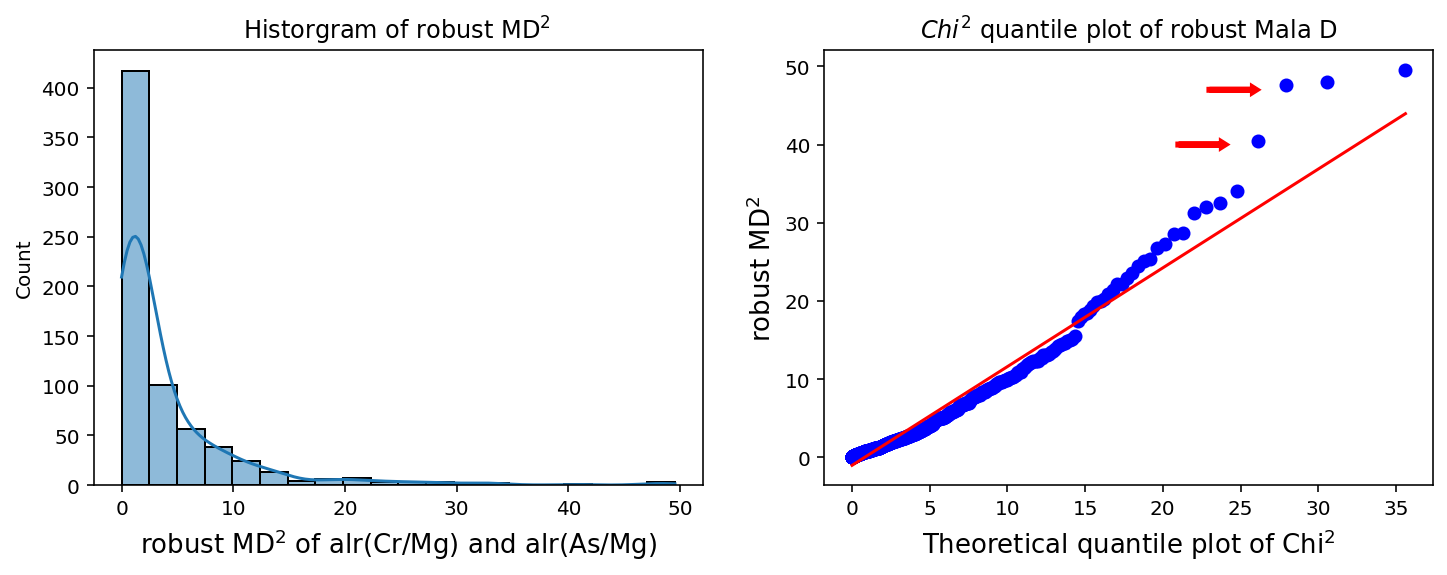

In [ ]:
plt.figure(figsize=(12,4))
## plot histograme of robust MD
plt.subplot(121)
sns.histplot(np.square(X_maha_rob), kde=True, bins=20)
plt.xlabel('robust MD$^2$ of alr(Cr/Mg) and alr(As/Mg)', fontsize = 13)
plt.title('Historgram of robust MD$^2$ ')
## Chi squared quantile plot
plt.subplot(122)
chi2_param = stats.chi2.fit(np.square(X_maha_rob))
stats.probplot(np.square(X_maha_rob), dist = stats.chi2, sparams = chi2_param, fit = True, plot=plt)
plt.title('$Chi^2$ quantile plot of robust Mala D')
plt.xlabel('Theoretical quantile plot of Chi$^2$', fontsize = 13)
plt.ylabel('robust MD$^2$', fontsize = 13)
plt.arrow(21, 40, 3, 0, length_includes_head=True, color='r',
          linewidth=3, head_width=0.5, head_length=0.2)
plt.arrow(23, 47, 3, 0, length_includes_head=True, color='r',
          linewidth=3, head_width=0.5, head_length=0.2)
plt.show()

Here, we take 95% confidence interval (95th quantile) of the $Chi^2$ distribution to classify outliers. We draw a elliptical boundary based on the corresponding Mahalanobis distance. This boundary classifies the outliers (figure below). 


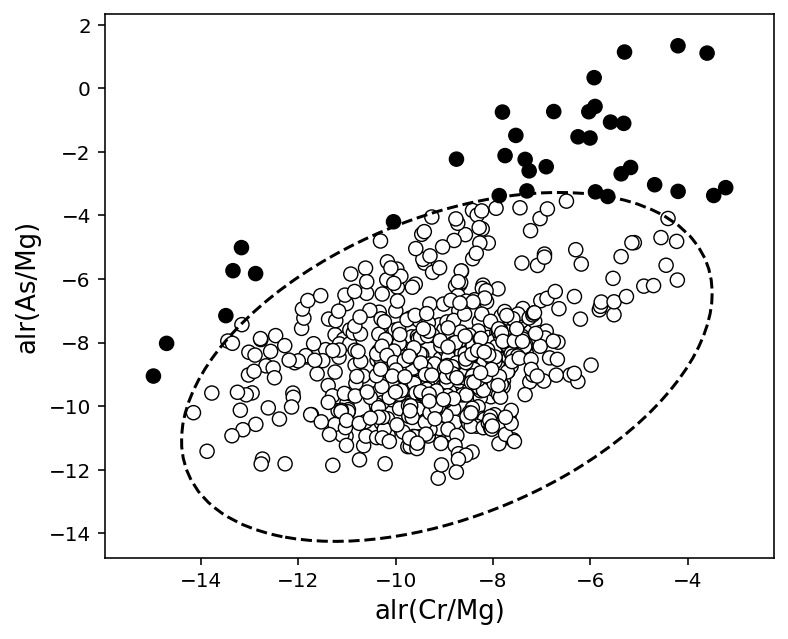

In [ ]:
boundary = np.quantile(np.square(X_maha_rob),0.95)
outlier_index = (np.square(X_maha_rob)>= boundary)
# plot results
plt.figure(figsize=(6,5))

plt.scatter(X[:, 0], X[:, 1], s=50, c=outlier_index, cmap = 'Greys',edgecolor='k', linewidths=0.7)

cbar.set_label('Mahalanobis distance')
a = plt.contour(xx, yy, np.sqrt(mahal_rob_cov), levels=[np.sqrt(boundary)], colors='k', linestyles='--')
plt.title
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.show()


You can also change boundary size by choosing different quantile. But be aware that the change of bounary size will change your confidence levels. 

We project the detected outliers back to the maps of Cr and As. 

Compare the the results to the univariate outliers. What are the differences?

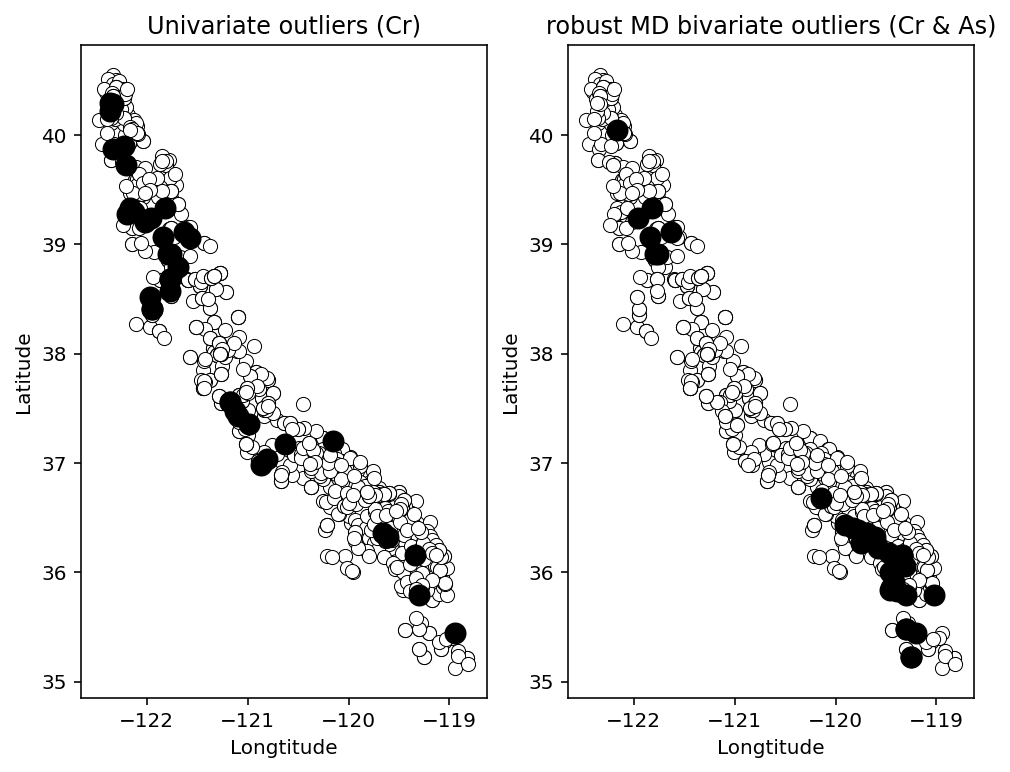

In [ ]:
plt.figure(figsize=(8,6))
plt.subplot(121)
pltdata = np.log(data['Cr (ppb)'].values)
## determin boundary by quantiles
p_025, p_975 = np.quantile(pltdata, 0.025), np.quantile(pltdata, 0.975)
Uoutlier_index = (pltdata>=p_975)|(pltdata<=p_025)

plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][Uoutlier_index],
            data['Latitude'][Uoutlier_index],     
            c = 'k',s=100)

plt.title('Univariate outliers (Cr)')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')


plt.subplot(122)

boundary = np.quantile(np.square(X_maha_rob),0.95)
outlier_index = (np.square(X_maha_rob)>= boundary)
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][outlier_index],
            data['Latitude'][outlier_index],             
            c = 'k',s=100)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

plt.title('robust MD bivariate outliers (Cr & As)')

plt.show()

### Bivariate outliers $\neq$ Univariate outliers

Below we compare the bivariate outliers and univariate outliers. 

The rectangular is univariate outlier boundary determined by 2.5% and 97.5% quantiles. The ellipse is from Mahalanobis distance outlier detection. 



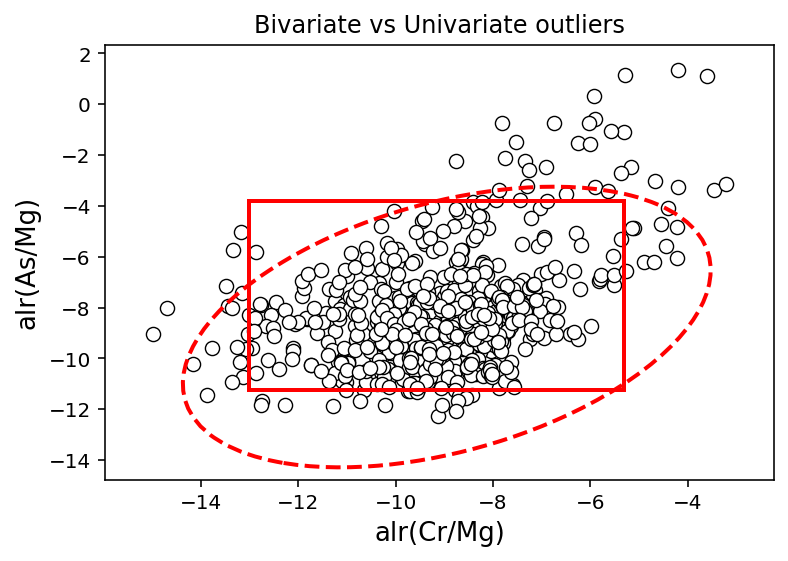

In [ ]:
import matplotlib.patches as patches

fig,ax = plt.subplots(1)

# Draw the ellipse boundary
ax.scatter(X[:, 0], X[:, 1], s=50, c='w', edgecolor='k', linewidths=0.7)
a = plt.contour(xx, yy, np.sqrt(mahal_rob_cov), levels=[np.sqrt(boundary)], 
                colors='r', linewidths = 2, linestyles='--')
# Create a Rectanglar based on 2.5nd and 97.5th quantile of each variable. 
cr_2nd, cr_98th = np.quantile(X[:, 0],0.025), np.quantile(X[:, 0],0.975)
as_2nd, as_98th = np.quantile(X[:, 1],0.025), np.quantile(X[:, ],0.975)

rect = patches.Rectangle((cr_2nd, as_2nd), cr_98th-cr_2nd, as_98th- as_2nd, 
                         linewidth=2, edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.title('Bivariate vs Univariate outliers')
plt.show()

The plot shows a significant difference between bivariate and univariate outliers. Which outlier detection is more robust?

## <font color='green'> [Advanced] Outlier detection using machine learning

### <font color='green'> One-class SVM


Another pouplar outlier detection method is one-class support-vector machine (**one-class SVM**). 

Different from Mahalanobis distance, the one-class SVM aims to find a minimum spherical boundary around most data samples: 

$$\min_{R,a}||R||$$

subject to 
$$||x^{(l)}-a||^2<=R^2,   \forall l \in 1, 2, ..., L$$
where R is the radius of the circle. $a$ is the center of data samples. $x^{(l)}$ is each sample of the data. $L$ is size of the targeted data poplulation.

Here, we are looking for a minimum spherical boundary that fits 95% of Cr and As data samples.

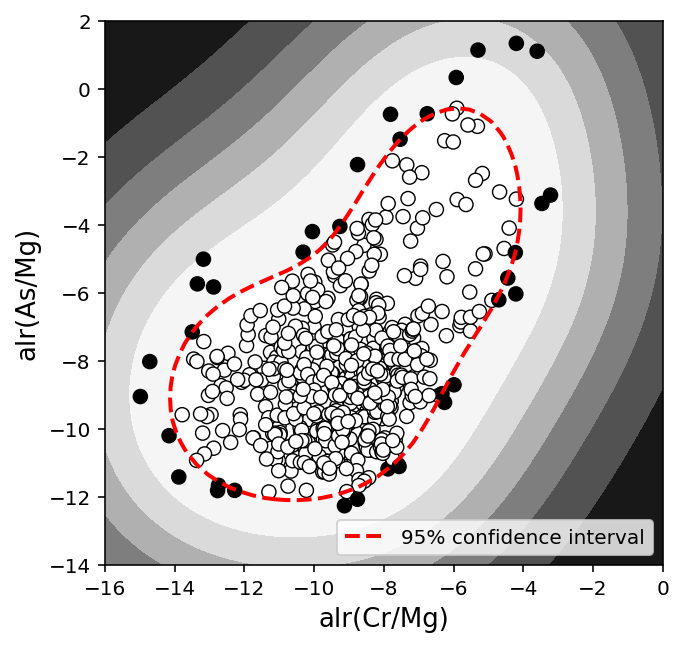

In [ ]:
outlier_proportion = 0.05
clf = svm.OneClassSVM(nu=outlier_proportion, kernel='rbf',gamma=0.05)
clf.fit(X)
y_pred = clf.predict(X)
scores_pred = clf.decision_function(X)
xx, yy = np.meshgrid(np.linspace(-16,0),
                     np.linspace(-14,2))

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

frontier = stats.scoreatpercentile(scores_pred, outlier_proportion*100)

plt.figure(figsize=(5,5))
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7),cmap="Greys_r")
a = plt.contour(xx, yy, Z, levels=[frontier], linewidths=2, colors='r', linestyles='--')
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='binary_r', s=50, edgecolor='k',linewidths=0.7)
plt.legend([a.collections[0]], ['95% confidence interval'], loc='lower right')
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.show()


Next, we also project the dectected outliers to their central valley. 
Compare the one-class SVM detected outliers (black dots) with the outliers from Mahalanobis distance. What do the differences tells us? 

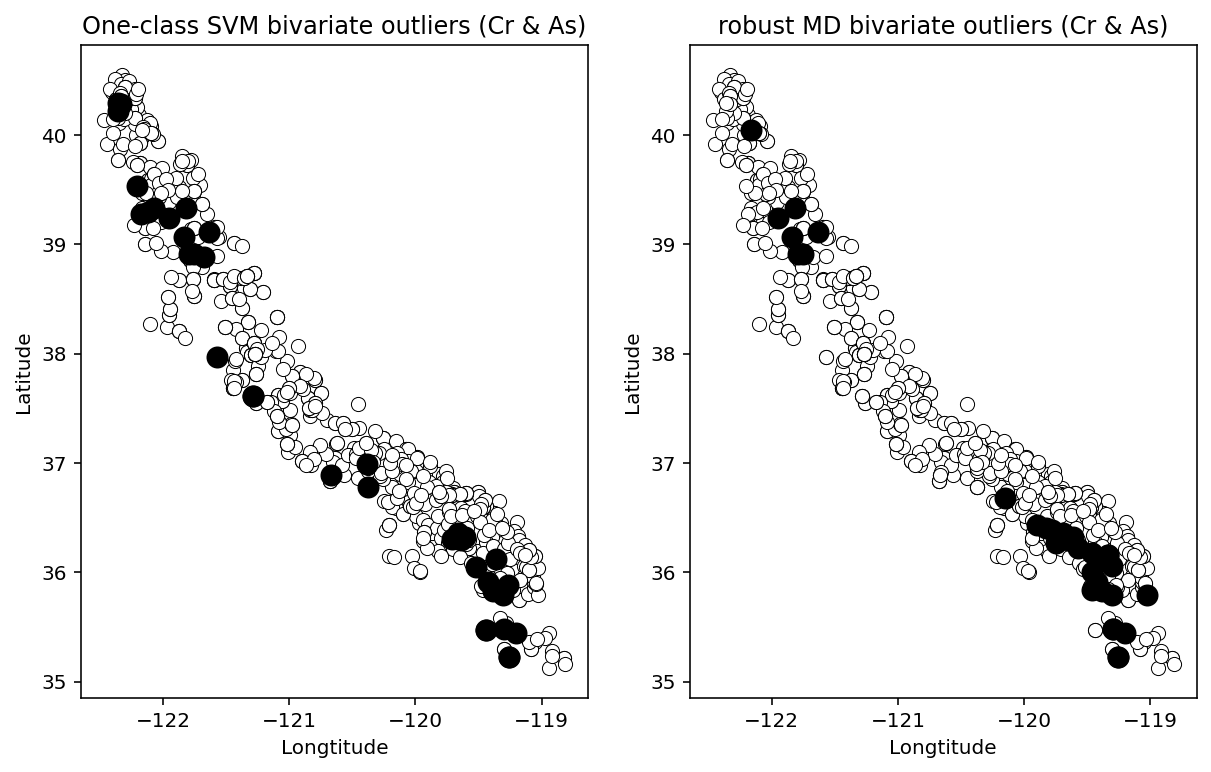

In [ ]:
plt.figure(figsize=(10,6))

plt.subplot(121)
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][y_pred==-1],
            data['Latitude'][y_pred==-1],             
            c = 'k',s=100)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('One-class SVM bivariate outliers (Cr & As)')

plt.subplot(122)
boundary = np.quantile(np.square(X_maha_rob),0.95)
outlier_index = (np.square(X_maha_rob)>= boundary)
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][outlier_index],
            data['Latitude'][outlier_index],             
            c = 'k',s=100)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')

plt.title('robust MD bivariate outliers (Cr & As)')
plt.show()

### <font color='green'> Isolation forest 

Both Mahalanobis distance and one-class SVM detect outliers by building boundaries. Can we detect outliers without using boundaries?


**Isolation forest** is a machine learning method that isolates outliers by building trees.

As the figure shows below, isolation forest randomly splits the data samples between their max and min values. If we keep spliting until every data sample is isolated, the whole dataset can be repsented by a tree structure. The tree path lengths are the numbers of spliting required to isolate each data node. 

An outlier $X_o$ will have the shortest tree path, because it requires the least spliting steps. But for data $X_i$ in the main population, it will have the longest tree path. 

<img src='https://drive.google.com/uc?export=view&id=1Yhkn9jaS1CXRCxofxpLDOklDC8AoCwFw' width=80% />

Isolation forest does not require the data to have a specific distribution/shape, which can be its advantage in some applications.

We test isolation forest by detecting outliers in Cr and As. The results are shown below (outliers colored as black)

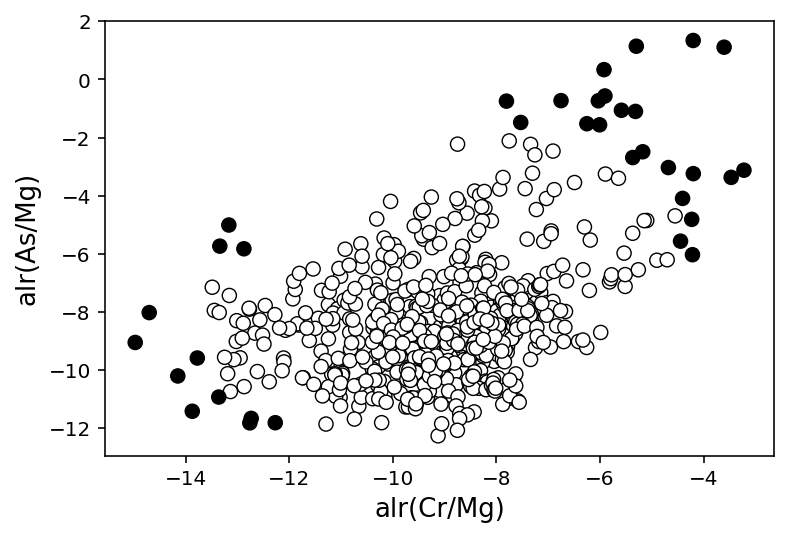

In [ ]:
# determine outlier proportions
outlier_proportion = 0.05
# fit to isolation forest
clf = IsolationForest(contamination=outlier_proportion, random_state=9)
clf.fit(X)
y_pred = clf.predict(X)
scores_pred = clf.decision_function(X)

frontier = stats.scoreatpercentile(scores_pred, outlier_proportion*100)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='binary_r', s=50, edgecolor='k',linewidths=0.7)
plt.xlabel('alr(Cr/Mg)', fontsize = 13)
plt.ylabel('alr(As/Mg)', fontsize = 13)
plt.show()

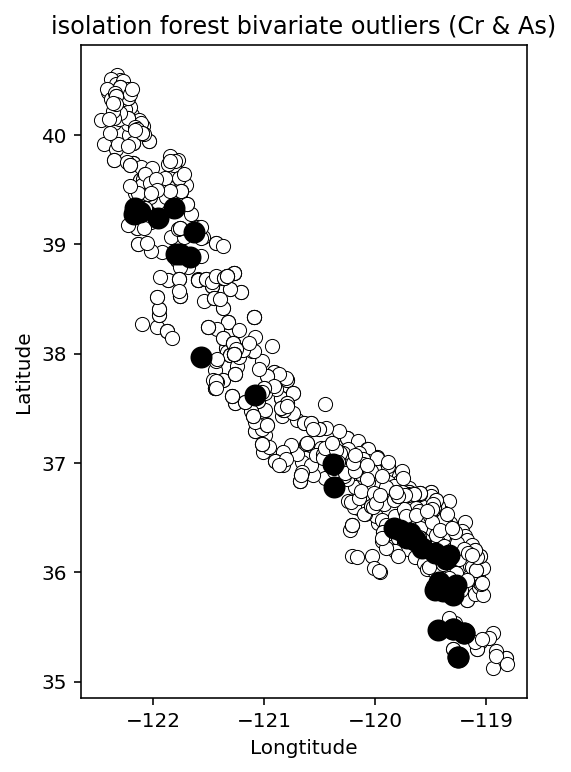

In [ ]:
plt.figure(figsize=(4,6))
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolors='k', linewidths=0.5, s=50)
plt.scatter(data['Longitude'][y_pred==-1],
            data['Latitude'][y_pred==-1],             
            c = 'k',s=100)
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.title('isolation forest bivariate outliers (Cr & As)')
plt.show()

<img src='https://drive.google.com/uc?export=view&id=142QZEP18UBeK5uNbRO9szXsc_Ub4E9Lj' width=50% />

https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_anomaly_comparison.html#sphx-glr-auto-examples-miscellaneous-plot-anomaly-comparison-py 



# Detect outliers from all 22 geochemicals


### Multivariate outliers
The central valley geochemistry dataset consists of totally 22 geochemical elements. How would you detect outliers for all of them?

This is a typical multivariate outlier detection problem. Each variable (of the 22 elements) has its own distribution pattern and interactions with all the other variables. Detecting multivariate outliers therfore can be more complex. 

The first challenge is to visualize the high-dimensional dataset. The 3D figure below plots distribution of three elements - Cr, As, and U. Can you visually observe any outliers? You could draw a sphere or ellipsoid as the outlier boundary. 



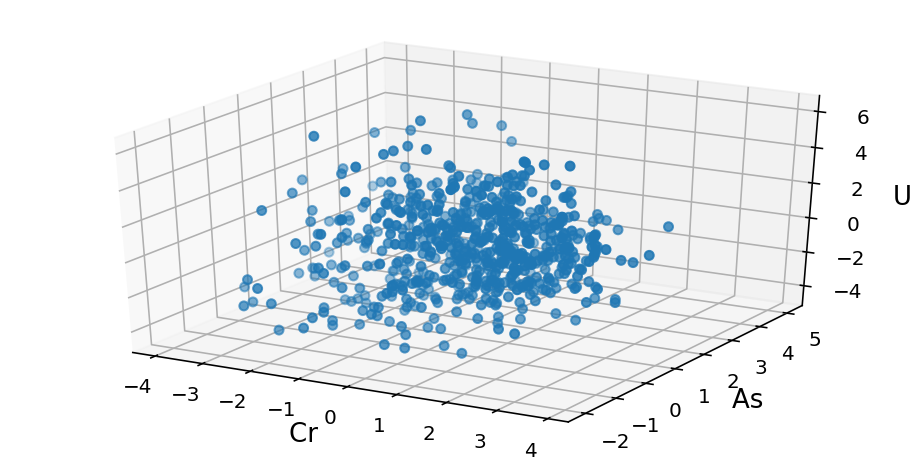

In [ ]:
fig = plt.figure(figsize=(8,4)) # create new figure
ax = fig.add_subplot(projection='3d')
ax.scatter(np.log(data['Cr (ppb)']), np.log(data['As (ppb)']), np.log(data['U (ppb)']))
ax.set_xlabel('Cr ', fontsize = 13)
ax.set_ylabel('As ', fontsize = 13)
ax.set_zlabel('U ', fontsize = 13)
plt.show()

Have a look of the raw geochemistry dataset below. How would you make a outlier detection plot that can visualize all the 22 dimensions?

In [ ]:
data.head()

,Latitude,Longitude,SOURCE,SOURCE.NAM,OTHER.NAME,WELL.ID,Al (ppb),As (ppb),Ba (ppb),Ca (ppb),Cl (ppb),Cr (ppb),Cu (ppb),F (ppb),Fe (ppb),K (ppb),Mg (ppb),Mn (ppb),Mo (ppb),Ni (ppb),NO3 (ppb),Pb (ppb),Se (ppb),SO4 (ppb),Sr (ppb),U (ppb),V (ppb0,Zn (ppb),Cr_level,Cr_level1
0,39.767667,-121.781556,USGS,CAMP-ES-15,CAMP-ES-15,CAMP-ES-15,2.6,0.79,8.62,17700.0,3260.0,0.75,0.76,130.0,3.2,1130.0,10300.0,0.28,0.245,0.28,474.0,0.341,0.05,3410.0,135.0,0.117068,20.0,2.0,0,Normal Cr
1,37.757111,-120.799278,USGS,CE-QPC-01,CE-QPC-01,CE-QPC-01,6.6,1.20,43.10,24400.0,8890.0,0.92,2.50,80.0,4.0,2650.0,9310.0,0.40,0.776,1.18,4390.0,2.690,0.05,7580.0,309.0,0.356680,7.0,26.1,0,Normal Cr
2,37.757111,-120.799278,USGS,CE-QPC-01,CE-QPC-01,CE-QPC-01,1.5,1.30,43.20,22800.0,6650.0,0.96,2.10,160.0,8.4,2660.0,10200.0,0.34,0.740,0.20,4340.0,1.130,0.08,10500.0,316.0,0.307840,7.3,28.6,0,Normal Cr
3,37.641167,-120.745500,USGS,CE-QPC-02,CE-QPC-02,CE-QPC-02,2.6,3.90,125.00,22100.0,18900.0,1.80,0.80,170.0,6.0,4490.0,14400.0,0.26,0.526,0.43,3990.0,0.068,0.06,10400.0,338.0,0.788840,17.9,45.8,1,Normal Cr
4,37.641167,-120.745500,USGS,CE-QPC-02,CE-QPC-02,CE-QPC-02,14.3,4.30,91.50,30500.0,11400.0,1.20,1.60,170.0,37.1,3950.0,19600.0,3.20,0.382,0.27,6800.0,0.243,0.11,10500.0,291.0,1.080400,19.7,2.8,1,Normal Cr


### Parallel coordinates plot (PCP)

Parallel coordinates plot (PCP) is a powerful approach to visualize high-dimensional data. In the plot, each data dimension will plotted in its own parallel coordinate. Below we use PCP to plot the closure of the raw geochemical data.

In [ ]:
# Load geochem dataset, groundwater chemistry in Central Valley
! git clone https://github.com/sdyinzhen/GS240_resources

fatal: destination path 'GS240_resources' already exists and is not an empty directory.


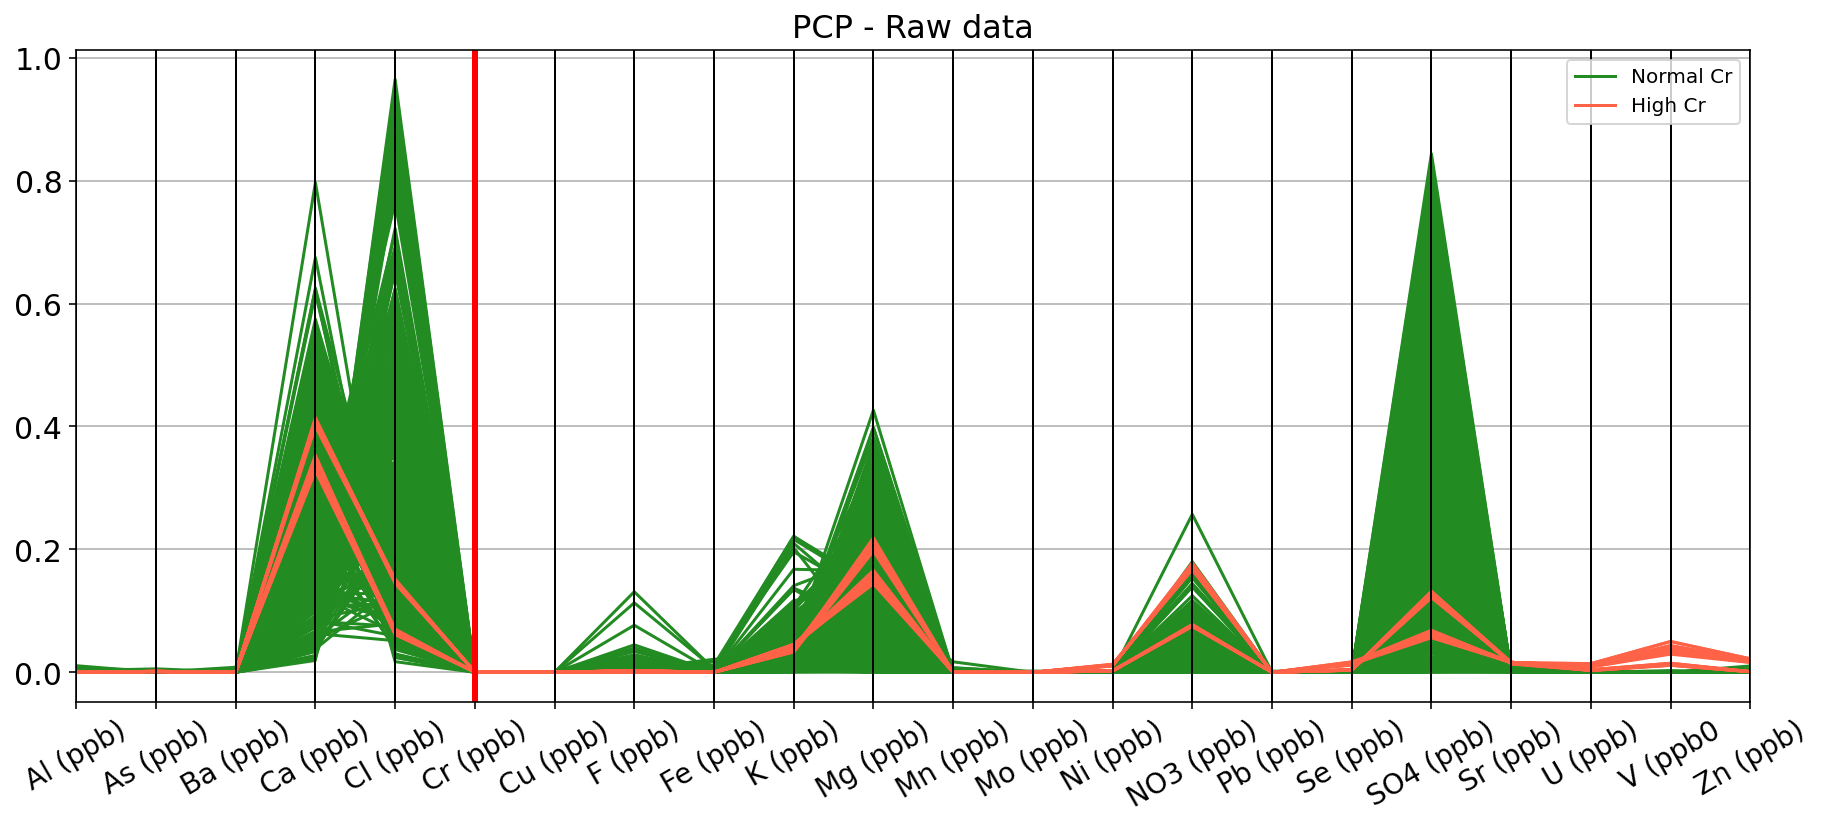

In [ ]:
# load data
data = pd.read_csv('/content/GS240_resources/oultliers/data_outlier.csv')
compositional_data = np.array(data.values[:,6:(6+22)],dtype = 'float64')

subdata = data[data.columns[6:6+22]]
subdata = subdata.div(subdata.sum(axis=1), axis=0)
subdata['Cr_level1'] = data['Cr_level1']

plt.figure(figsize=(15, 6))
pd.plotting.parallel_coordinates(
    subdata,
    class_column = 'Cr_level1',  color=["forestgreen", "tomato","dodgerblue", 'black', 'm']
    )
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 14, rotation=30)
plt.axvline(x=5,  linewidth=3, color='r')

plt.title('PCP - Raw data', fontsize=16)
plt.show()

We can see the vertical variations of each geochemical elements along vertical coordinates. However, the problem is that it is impossible to detect outliers from the plot.

Based on compositional data analysis that we just learnt, we perform a log-ratio transformation. We use the simple additive log-ratio(alr) transformation, with Ba element as the common denominator. 

After performing alr, we re-plot the tranformed geochemical data on PCP. 

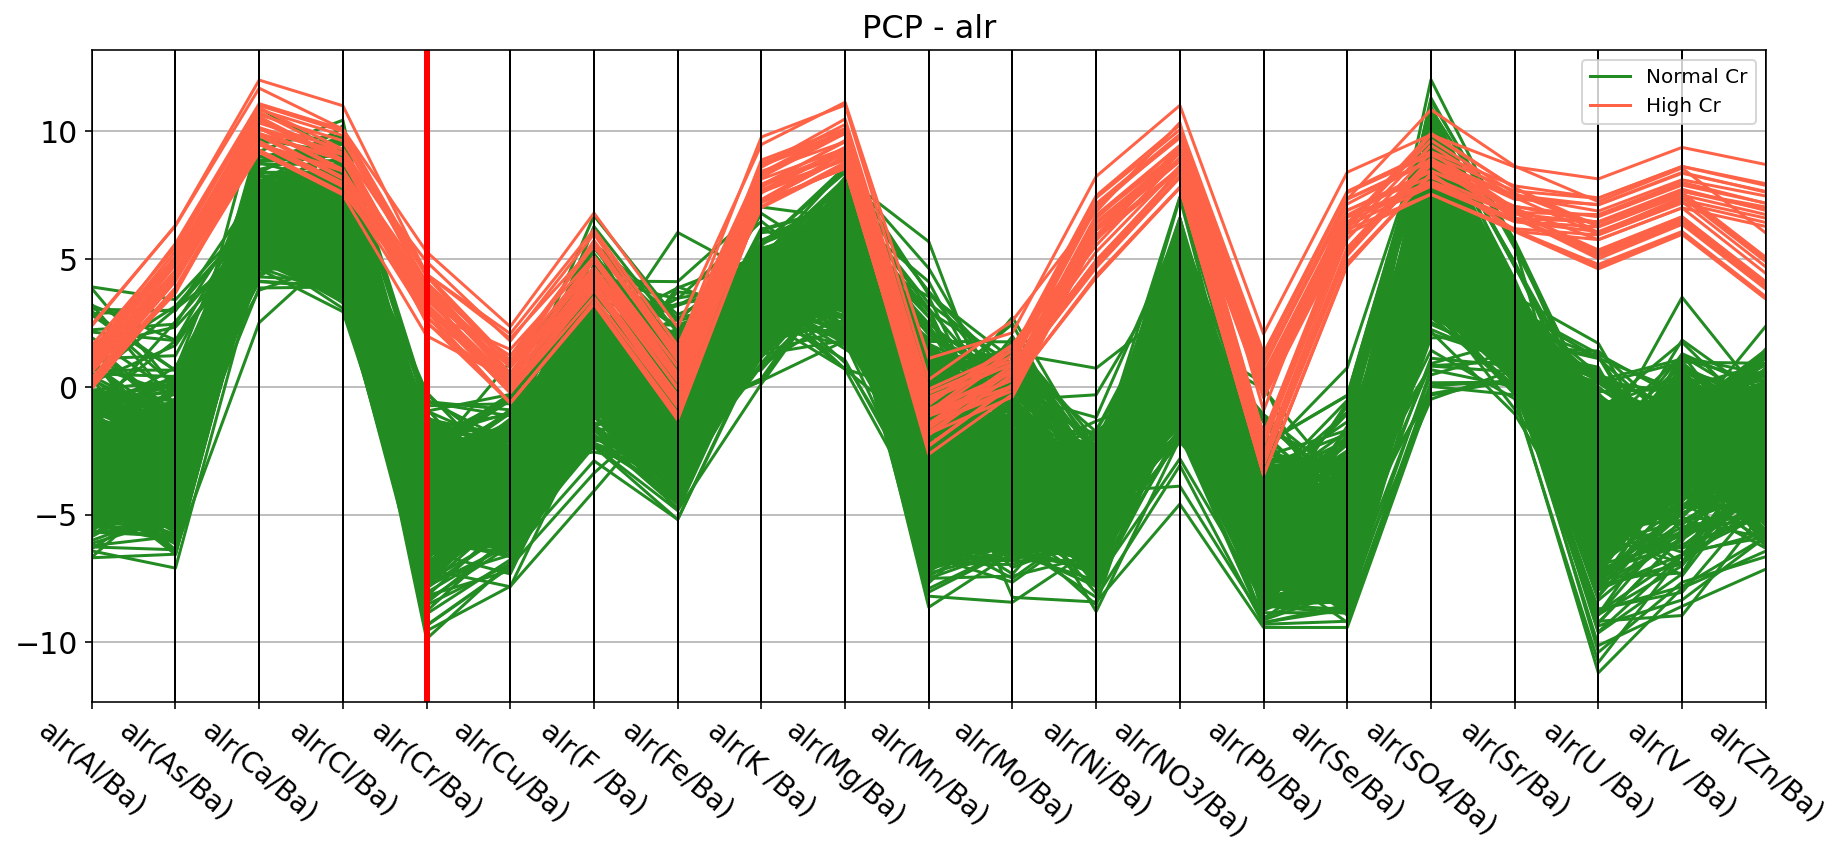

In [ ]:
choice_d = 2 # 'Ba'

data = pd.read_csv('/content/GS240_resources/oultliers/data_outlier.csv')
compositional_data = np.array(data.values[:,6:(6+22)],dtype = 'float64')

lr_data_o = alr(compositional_data, denominator_idx=choice_d)
lr_type = 'alr'
lr_data_col_names = []
name_ind = np.delete(np.arange(6,6+22), choice_d)
for i in name_ind:
  if data.columns[i][2]=='(' or data.columns[i][2]==' ':
    lr_data_col_names.append(lr_type+'('+data.columns[i][:2]+'/Ba)')
  else:
    lr_data_col_names.append(lr_type+'('+data.columns[i][:3]+'/Ba)')
lr_data_o = pd.DataFrame(lr_data_o, columns = lr_data_col_names[:compositional_data.shape[1]])
lr_data_o['Cr_level'] = data['Cr_level1']

# make PCP plot
plt.figure(figsize=(15, 6))
pd.plotting.parallel_coordinates(
    lr_data_o,
    class_column = 'Cr_level',  color=["forestgreen", "tomato","dodgerblue", 'black', 'm']
    )
plt.axvline(x=4,  linewidth=3, color='r')
plt.title('PCP - '+lr_type, fontsize=16)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 14, rotation=-40)
plt.show()

Now it is very obvious that the Cr contaminated data samples (High Cr) stands out as outliers from the normal Cr population.

**Question**:

Make PCP plots for clr and ilr transformed geochemical data. What difference do you observe?

### Multivariate outlier detection using Mahalanobis distance 

Multivariate outliers can also be classified using robust Mahalanobis distances, similar to bivariate outlier detection. 

Below we caculate Mahalanobis distances for all the data samples with 22 dimensions. 


In [ ]:
data.head()

,Latitude,Longitude,SOURCE,SOURCE.NAM,OTHER.NAME,WELL.ID,Al (ppb),As (ppb),Ba (ppb),Ca (ppb),Cl (ppb),Cr (ppb),Cu (ppb),F (ppb),Fe (ppb),K (ppb),Mg (ppb),Mn (ppb),Mo (ppb),Ni (ppb),NO3 (ppb),Pb (ppb),Se (ppb),SO4 (ppb),Sr (ppb),U (ppb),V (ppb0,Zn (ppb),Cr_level,Cr_level1
0,39.767667,-121.781556,USGS,CAMP-ES-15,CAMP-ES-15,CAMP-ES-15,2.6,0.79,8.62,17700.0,3260.0,0.75,0.76,130.0,3.2,1130.0,10300.0,0.28,0.245,0.28,474.0,0.341,0.05,3410.0,135.0,0.117068,20.0,2.0,0,Normal Cr
1,37.757111,-120.799278,USGS,CE-QPC-01,CE-QPC-01,CE-QPC-01,6.6,1.20,43.10,24400.0,8890.0,0.92,2.50,80.0,4.0,2650.0,9310.0,0.40,0.776,1.18,4390.0,2.690,0.05,7580.0,309.0,0.356680,7.0,26.1,0,Normal Cr
2,37.757111,-120.799278,USGS,CE-QPC-01,CE-QPC-01,CE-QPC-01,1.5,1.30,43.20,22800.0,6650.0,0.96,2.10,160.0,8.4,2660.0,10200.0,0.34,0.740,0.20,4340.0,1.130,0.08,10500.0,316.0,0.307840,7.3,28.6,0,Normal Cr
3,37.641167,-120.745500,USGS,CE-QPC-02,CE-QPC-02,CE-QPC-02,2.6,3.90,125.00,22100.0,18900.0,1.80,0.80,170.0,6.0,4490.0,14400.0,0.26,0.526,0.43,3990.0,0.068,0.06,10400.0,338.0,0.788840,17.9,45.8,1,Normal Cr
4,37.641167,-120.745500,USGS,CE-QPC-02,CE-QPC-02,CE-QPC-02,14.3,4.30,91.50,30500.0,11400.0,1.20,1.60,170.0,37.1,3950.0,19600.0,3.20,0.382,0.27,6800.0,0.243,0.11,10500.0,291.0,1.080400,19.7,2.8,1,Normal Cr


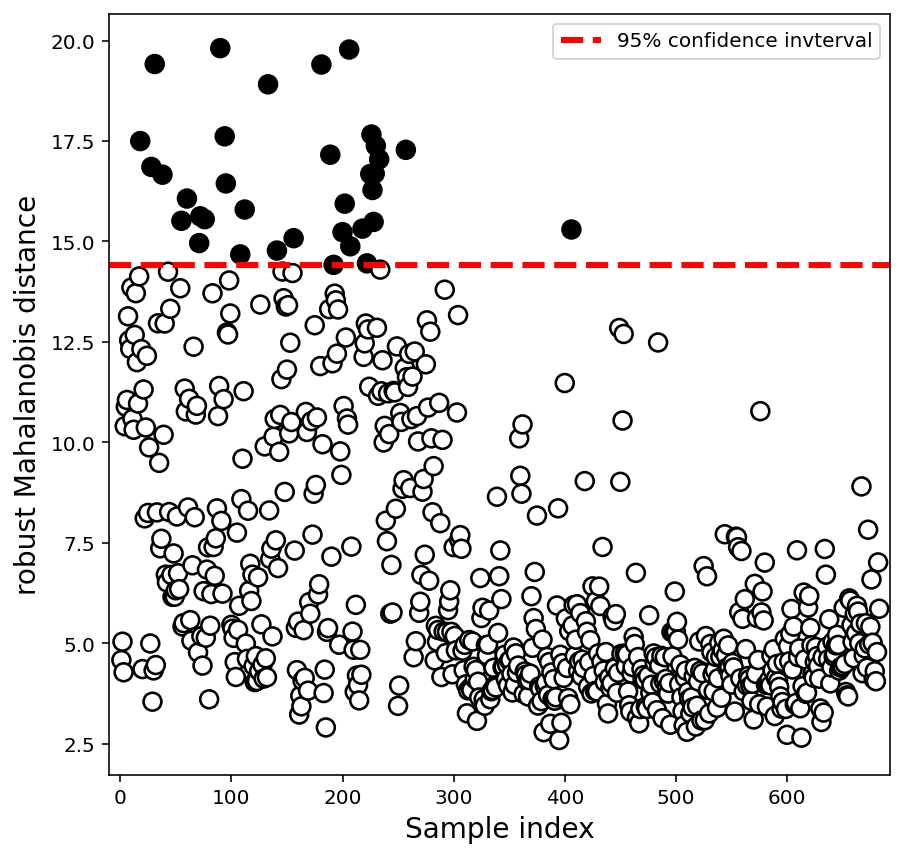

In [ ]:
# alr transformation
choice_d = 2 # 'Ba'

# Load geochem dataset, groundwater chemistry in Central Valley
data = pd.read_csv('/content/GEOLSCI6_EARTHSYS100A/StatsGeochem/Datapoints-CentralValley-Groundwater-Jan2019.csv')
compositional_data = np.array(data.values[:,6:(6+22)],dtype = 'float64')
lr_data = alr(compositional_data, denominator_idx=choice_d)

# calculate MD
rob_cov = MinCovDet().fit(lr_data)
X_maha = np.sqrt(rob_cov.mahalanobis(lr_data))
threshold = np.quantile(X_maha,0.95)
outlier_index = (X_maha>= threshold)
# plot outliers
plt.figure(figsize=(7, 7))

plt.scatter(np.arange(1,(len(X_maha)+1)), X_maha, c=outlier_index,     \
            cmap ='Greys', s=80,  \
            linewidths=1.3, edgecolor='k')

plt.hlines(threshold, xmin= -10, xmax=(len(X_maha)+10), colors='red', linewidths=3, 
           linestyles='--', label='95% confidence invterval')
plt.legend()
plt.xlim(-10, (len(X_maha)+10))

plt.ylabel('robust Mahalanobis distance', fontsize=14)
plt.xlabel('Sample index', fontsize=14)
plt.show()

In the plot, each point represents the robust MD for a geochemical data sample. Same as the bivariate outlier detection, we take a 95% confidence interval (red line). It gives us 95 confidence that the samples above threshold line are outliers. 

We can also plot the outliers on central valley map to identify the locations of geochemical anomalies. Compare with the landuse map. You can see how the geochemical anomalies are correlated to human activities. 

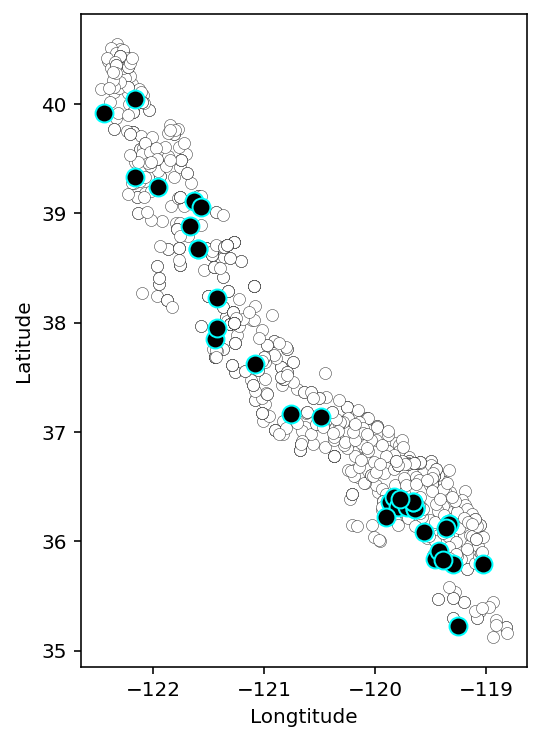

In [ ]:
plt.figure(figsize=(4,6))
plt.scatter(data['Longitude'],data['Latitude'], c = 'w', edgecolor='k', linewidths=0.2)
plt.scatter(data['Longitude'][outlier_index],
            data['Latitude'][outlier_index],
            c='k', s=80, edgecolor='aqua')
plt.xlabel('Longtitude')
plt.ylabel('Latitude')
plt.show()